## First training and testing on ESC-50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import self-implemented torch dataset
from datasets import ESCDataset

In [2]:
window_seconds = 5.0 # The duration per sample in seconds
                     # This affects the sample size (length of the time axis in mel spectrogram),
                     # and also the final accuracy

train_data = ESCDataset(root='ESC50', 
                        esc50=True, 
                        val_fold=4,
                        train=True,
                        download=True,
                        window_seconds=window_seconds)
valid_data = ESCDataset(root='ESC50', 
                        esc50=True, 
                        val_fold=4,
                        train=False,
                        download=False,
                        window_seconds=window_seconds)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))
print('Sample shape', train_data.data[0].shape)

Download not needed, files already on disk.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:10<00:00, 37.23it/s]

train data length 1600
valid data length 400
Sample shape (1, 64, 431)


In [3]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  4%|██████▊                                                                                                                                                                  | 1/25 [00:02<00:52,  2.17s/it]

Epoch - 1 Train-Loss : 2.6422483909130094
Epoch - 1 Valid-Loss : 1.8467053365707398 Valid-Accuracy : 0.5175


  8%|█████████████▌                                                                                                                                                           | 2/25 [00:03<00:44,  1.95s/it]

Epoch - 2 Train-Loss : 1.3905436933040618
Epoch - 2 Valid-Loss : 1.3600353240966796 Valid-Accuracy : 0.6025


 12%|████████████████████▎                                                                                                                                                    | 3/25 [00:05<00:41,  1.88s/it]

Epoch - 3 Train-Loss : 0.9130963176488877
Epoch - 3 Valid-Loss : 1.1590389442443847 Valid-Accuracy : 0.6475


 16%|███████████████████████████                                                                                                                                              | 4/25 [00:07<00:38,  1.85s/it]

Epoch - 4 Train-Loss : 0.7297701895236969
Epoch - 4 Valid-Loss : 1.1368911504745483 Valid-Accuracy : 0.685


 20%|█████████████████████████████████▊                                                                                                                                       | 5/25 [00:09<00:36,  1.83s/it]

Epoch - 5 Train-Loss : 0.5655377812683582
Epoch - 5 Valid-Loss : 1.169051638841629 Valid-Accuracy : 0.6975


 24%|████████████████████████████████████████▌                                                                                                                                | 6/25 [00:11<00:34,  1.82s/it]

Epoch - 6 Train-Loss : 0.4047729255631566
Epoch - 6 Valid-Loss : 0.9598542481660843 Valid-Accuracy : 0.7375


 28%|███████████████████████████████████████████████▎                                                                                                                         | 7/25 [00:12<00:32,  1.82s/it]

Epoch - 7 Train-Loss : 0.2805980003625155
Epoch - 7 Valid-Loss : 0.9242430555820466 Valid-Accuracy : 0.725


 32%|██████████████████████████████████████████████████████                                                                                                                   | 8/25 [00:14<00:30,  1.81s/it]

Epoch - 8 Train-Loss : 0.2550621241144836
Epoch - 8 Valid-Loss : 0.8784880477190018 Valid-Accuracy : 0.78


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 9/25 [00:16<00:28,  1.81s/it]

Epoch - 9 Train-Loss : 0.23618241423740982
Epoch - 9 Valid-Loss : 0.9676668047904968 Valid-Accuracy : 0.7475
Changed learning rate to 2e-05


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 10/25 [00:18<00:27,  1.81s/it]

Epoch - 10 Train-Loss : 0.11360545314848423
Epoch - 10 Valid-Loss : 0.7008350773155689 Valid-Accuracy : 0.825


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 11/25 [00:20<00:25,  1.81s/it]

Epoch - 11 Train-Loss : 0.06641423872672021
Epoch - 11 Valid-Loss : 0.684156163930893 Valid-Accuracy : 0.83


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 12/25 [00:21<00:23,  1.81s/it]

Epoch - 12 Train-Loss : 0.054130306197330356
Epoch - 12 Valid-Loss : 0.6715246576070786 Valid-Accuracy : 0.835


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 13/25 [00:23<00:21,  1.80s/it]

Epoch - 13 Train-Loss : 0.04177894443273544
Epoch - 13 Valid-Loss : 0.6487887129187584 Valid-Accuracy : 0.8375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 14/25 [00:25<00:19,  1.80s/it]

Epoch - 14 Train-Loss : 0.029508516497444362
Epoch - 14 Valid-Loss : 0.6718662330508232 Valid-Accuracy : 0.8225


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 15/25 [00:27<00:18,  1.80s/it]

Epoch - 15 Train-Loss : 0.03891343037597835
Epoch - 15 Valid-Loss : 0.6627867516875267 Valid-Accuracy : 0.83


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 16/25 [00:29<00:16,  1.80s/it]

Epoch - 16 Train-Loss : 0.023749368861317635
Epoch - 16 Valid-Loss : 0.617755361199379 Valid-Accuracy : 0.845


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 17/25 [00:31<00:14,  1.82s/it]

Epoch - 17 Train-Loss : 0.01812117581255734
Epoch - 17 Valid-Loss : 0.6126582390069961 Valid-Accuracy : 0.845


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 18/25 [00:32<00:12,  1.82s/it]

Epoch - 18 Train-Loss : 0.023062088044825943
Epoch - 18 Valid-Loss : 0.6083880561590195 Valid-Accuracy : 0.8475


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 19/25 [00:34<00:10,  1.82s/it]

Epoch - 19 Train-Loss : 0.019684490696527064
Epoch - 19 Valid-Loss : 0.6350253148376942 Valid-Accuracy : 0.835
Changed learning rate to 2e-06


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 20/25 [00:36<00:09,  1.82s/it]

Epoch - 20 Train-Loss : 0.0207171998382546
Epoch - 20 Valid-Loss : 0.6218732142448425 Valid-Accuracy : 0.83


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21/25 [00:38<00:07,  1.81s/it]

Epoch - 21 Train-Loss : 0.01946165965637192
Epoch - 21 Valid-Loss : 0.6324485957622528 Valid-Accuracy : 0.835


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22/25 [00:40<00:05,  1.82s/it]

Epoch - 22 Train-Loss : 0.01959920028457418
Epoch - 22 Valid-Loss : 0.6319440579414368 Valid-Accuracy : 0.8325


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 23/25 [00:41<00:03,  1.82s/it]

Epoch - 23 Train-Loss : 0.018131479627918452
Epoch - 23 Valid-Loss : 0.6443863317370415 Valid-Accuracy : 0.83


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 24/25 [00:43<00:01,  1.82s/it]

Epoch - 24 Train-Loss : 0.017460872845258563
Epoch - 24 Valid-Loss : 0.6250191135704517 Valid-Accuracy : 0.8425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:45<00:00,  1.82s/it]

Epoch - 25 Train-Loss : 0.01768804120598361
Epoch - 25 Valid-Loss : 0.6225137451291084 Valid-Accuracy : 0.8425


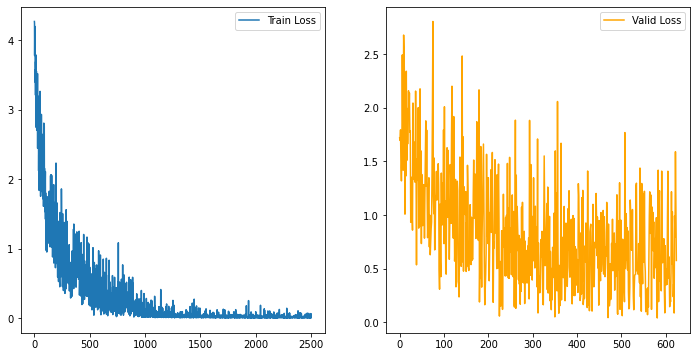

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
